In [ ]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display first few rows of each
print("Customers Data:")
print(customers.head())

print("\nProducts Data:")
print(products.head())

print("\nTransactions Data:")
print(transactions.head())

In [ ]:
combined_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Display merged data
print(combined_data.head())


In [3]:
# Total spending
customer_spending = combined_data.groupby('CustomerID')['TotalValue'].sum().reset_index(name='TotalSpending')

# Average transaction value
avg_transaction_value = combined_data.groupby('CustomerID')['TotalValue'].mean().reset_index(name='AvgTransactionValue')

# Most frequent product category
most_freq_category = combined_data.groupby(['CustomerID', 'Category']).size().reset_index(name='Count')
most_freq_category = most_freq_category.sort_values('Count', ascending=False).drop_duplicates('CustomerID')[['CustomerID', 'Category']]


In [ ]:
# Merge features
customer_features = customers.merge(customer_spending, on='CustomerID') \
                              .merge(avg_transaction_value, on='CustomerID') \
                              .merge(most_freq_category, on='CustomerID')

print(customer_features.head())

In [ ]:
# Create a copy to avoid SettingWithCopyWarning
clustering_data = customer_features[['CustomerID', 'Region', 'TotalSpending', 'AvgTransactionValue']].copy()

# Encode 'Region' as a numerical feature
clustering_data['Region'] = clustering_data['Region'].astype('category').cat.codes

print(clustering_data.head())


In [6]:
from sklearn.preprocessing import StandardScaler

# Drop 'CustomerID' as it’s not needed for clustering
features = clustering_data.drop('CustomerID', axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [7]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
k = 4  # You can experiment with this
kmeans = KMeans(n_clusters=k, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_features)


In [8]:
from sklearn.metrics import davies_bouldin_score

# Compute DB Index
db_index = davies_bouldin_score(scaled_features, clustering_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.0886283893378188


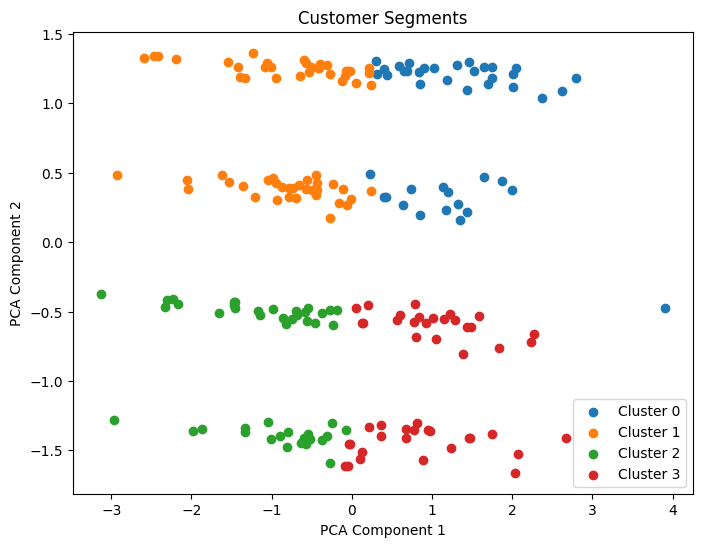

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in range(k):
    cluster_points = pca_features[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
